<a href="https://colab.research.google.com/github/tripuragorla/CMPE-297-Assignments/blob/main/Assignment%203/HuggingFaces_QuestionAnswering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers
!pip install wandb
!wandb login

     |████████████████████████████████| 290 kB 4.2 MB/s 
     |████████████████████████████████| 3.1 MB 62.2 MB/s 
     |████████████████████████████████| 243 kB 51.2 MB/s 
     |████████████████████████████████| 59 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 68.7 MB/s 
     |████████████████████████████████| 125 kB 94.6 MB/s 
     |████████████████████████████████| 596 kB 84.0 MB/s 
     |████████████████████████████████| 3.3 MB 69.6 MB/s 
     |████████████████████████████████| 895 kB 67.1 MB/s 
     |████████████████████████████████| 160 kB 61.9 MB/s 
     |████████████████████████████████| 192 kB 71.7 MB/s 
     |████████████████████████████████| 271 kB 83.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 139 kB 91.7 MB/s 
     |████████████████████████████████| 180

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (892 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
import transformers

print(transformers.__version__)

4.12.3


# Defining Checkpoint and Batch Size

In [ ]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = False
checkpoint = "distilbert-base-uncased"
batch_size = 20

## Loading the dataset

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/8.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
datasets["train"][0]

{'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']},
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'id': '5733be284776f41900661182',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'title': 'University_of_Notre_Dame'}

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,572a17261d04691400779760,East_Prussia,"The Kingdom of Prussia became the leading state of the German Empire after its creation in 1871. However, the Treaty of Versailles following World War I granted West Prussia to Poland and made East Prussia an exclave of Weimar Germany (the new Polish Corridor separating East Prussia from the rest of Germany), while the Memel Territory was detached and was annexed by Lithuania in 1923. Following Nazi Germany's defeat in World War II in 1945, war-torn East Prussia was divided at Joseph Stalin's insistence between the Soviet Union (the Kaliningrad Oblast in the Russian SFSR and the constituent counties of the Klaipėda Region in the Lithuanian SSR) and the People's Republic of Poland (the Warmian-Masurian Voivodeship). The capital city Königsberg was renamed Kaliningrad in 1946. The German population of the province was largely evacuated during the war or expelled shortly thereafter in the expulsion of Germans after World War II. An estimated 300,000 (around one fifth of the population) died either in war time bombings raids or in the battles to defend the province.[citation needed]",What well known treaty would eventually would grant West Prussia to Poland?,"{'text': ['Versailles'], 'answer_start': [120]}"
1,56df827c56340a1900b29c9c,Plymouth,"Antarctic explorers Robert Falcon Scott and Frank Bickerton both lived in the city. Artists include Beryl Cook whose paintings depict the culture of Plymouth and Robert Lenkiewicz, whose paintings investigated themes of vagrancy, sexual behaviour and suicide, lived in the city from the 1960s until his death in 2002. Illustrator and creator of children's series Mr Benn and King Rollo, David McKee, was born and brought up in South Devon and trained at Plymouth College of Art. Jazz musician John Surman, born in nearby Tavistock, has close connections to the area, evidenced by his 2012 album Saltash Bells. The avant garde prepared guitarist Keith Rowe was born in the city before establishing the jazz free improvisation band AMM in London in 1965 and MIMEO in 1997. The musician and film director Cosmo Jarvis has lived in several towns in South Devon and has filmed videos in and around Plymouth. In addition, actors Sir Donald Sinden and Judi Trott. George Passmore of Turner Prize winning duo Gilbert and George was born in the city, as was Labour politician Michael Foot whose family reside at nearby Trematon Castle.",Where do the family of Michael Foot live?,"{'text': ['Trematon Castle'], 'answer_start': [1110]}"
2,57337479d058e614000b5b42,Alfred_North_Whitehead,"Early followers of Whitehead were found primarily at the University of Chicago's Divinity School, where Henry Nelson Wieman initiated an interest in Whitehead's work that would last for about thirty years. Professors such as Wieman, Charles Hartshorne, Bernard Loomer, Bernard Meland, and Daniel Day Williams made Whitehead's philosophy arguably the most important intellectual thread running through the Divinity School. They taught generations of Whitehead scholars, the most notable of which is John B. Cobb, Jr.",Who id the most well-known Whitehead scholar?,"{'text': ['John B. Cobb'], 'answer_start': [498]}"
3,5733ff844776f41900661689,"Punjab,_Pakistan","Maharaja Ranjit Singh's death in the summer of 1839 brought political chaos and the subsequent battles of succession and the bloody infighting between the factions at court weakened the state. Relationships with neighbouring British territories then broke down, starting the First Anglo-Sikh War; this led to a British official being resident in Lahore and the annexation in 1849 of territory south of the Satluj to British India. After the Second Anglo-Sikh War in 1849, the Sikh Empire became the last territory to be merged into British India. In Jhelum 35 British soldiers of HM XXIV regiment were killed by the local resistance during the Indian Rebellion of 1857.[citation needed]",When was part of Punjab annexed into 

## Preprocessing data

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [ ]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

In [ ]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

how How


In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

23 26


In [ ]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1, 600
over 1,600


In [ ]:
pad_on_right = tokenizer.padding_side == "right"

In [ ]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
features = prepare_train_features(datasets['train'][:5])

In [ ]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]





## Fine-tuning model

In [ ]:
import wandb

wandb.init(project="Hugging-Faces Question Answering", entity="shivkumarganesh")

wandb: Currently logged in as: shivkumarganesh (use `wandb login --relogin` to force relogin)


In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

In [ ]:
model_name = checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
    push_to_hub=True,
    report_to="wandb"
)

PyTorch: setting up devices


In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
!transformers-cli login

WARNING! `transformers-cli login` is deprecated and will be removed in v5. Please use `huggingface-cli login` instead.

        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: gshiv.sk@gmail.com
Password: 
Login successful
Your token: WzaHsQsAChIaUsdmhWkAiNvzAiGalFfiqsTcayYdkiTtTAyGxxNPnKlVxlRqFxKonotYqiFJpsfFtcsWPYiZuaEGtMDEsTYsqPnbQMcURtXuycBdrfesWjFwPqUjGYBA 

Your token has been saved to /root/.huggingface/token


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:718: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
/content/distilbert-base-uncased-finetuned-squad is already a clone of https://huggingface.co/shivkumarganesh/distilbert-base-uncased-finetuned-squad. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 88524
  Num Epochs = 1
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 4427
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,1.303600,1.241403


Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-fine

TrainOutput(global_step=4427, training_loss=1.5535382136604925, metrics={'train_runtime': 1861.2239, 'train_samples_per_second': 47.562, 'train_steps_per_second': 2.379, 'total_flos': 8674451270424576.0, 'train_loss': 1.5535382136604925, 'epoch': 1.0})

In [ ]:
trainer.save_model("test-squad-trained")

Saving model checkpoint to test-squad-trained
Configuration saved in test-squad-trained/config.json
Model weights saved in test-squad-trained/pytorch_model.bin
tokenizer config file saved in test-squad-trained/tokenizer_config.json
Special tokens file saved in test-squad-trained/special_tokens_map.json


## Evaluation

In [ ]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [ ]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([20, 384]), torch.Size([20, 384]))

In [ ]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 46,  57,  78,  43, 118,  16,  72,  35,  16,  34,  73,  41,  80,  91,
         156,  35,  83,  91,  80,  58], device='cuda:0'),
 tensor([ 47,  58,  81,  44, 141, 109,  75,  37, 109,  36,  76,  42,  83,  94,
         158,  35,  83,  94,  83,  60], device='cuda:0'))

In [ ]:
n_best_size = 20

In [ ]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set  don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping.
***** Running Prediction *****
  Num examples = 10784
  Batch size = 20


In [ ]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [ ]:
max_answer_length = 30

In [ ]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 14.016314, 'text': 'Denver Broncos'},
 {'score': 12.297665,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 10.46706,
  'text': 'American Football Conference (AFC) champion Denver Broncos'},
 {'score': 10.296791, 'text': 'Broncos'},
 {'score': 10.278905, 'text': 'Carolina Panthers'},
 {'score': 9.187183,
  'text': 'The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 8.774601, 'text': 'Denver'},
 {'score': 8.748411,
  'text': 'American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 8.578142,
  'text': 'Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 8.475966, 'text': 'champion Denver Broncos'},
 {'score': 7.834507,
  'text': 'Denver Broncos defeated the National Football Conference (NFC'},
 {'score': 7.468534,
  'text': 'The American Football Conf

In [ ]:
datasets["validation"][0]["answers"]

{'answer_start': [177, 177, 177],
 'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']}

In [ ]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [ ]:
final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)

Post-processing 10570 example predictions split into 10784 features.


  0%|          | 0/10570 [00:00<?, ?it/s]

In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

Downloading:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

In [ ]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 71.92999053926206, 'f1': 81.22874651142251}

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to distilbert-base-uncased-finetuned-squad
Configuration saved in distilbert-base-uncased-finetuned-squad/config.json
Model weights saved in distilbert-base-uncased-finetuned-squad/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.36k/253M [00:00<?, ?B/s]

To https://huggingface.co/shivkumarganesh/distilbert-base-uncased-finetuned-squad
   1f2e9e7..3455cfa  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'args': 'plain_text'}}
To https://huggingface.co/shivkumarganesh/distilbert-base-uncased-finetuned-squad
   3455cfa..7e1a7d2  main -> main



'https://huggingface.co/shivkumarganesh/distilbert-base-uncased-finetuned-squad/commit/3455cfa0b5fbdf267575bcd09de6beac48737dfe'

In [ ]:
wandb.finish()

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▃▄▅▅▆▇██
train/global_step,▁▂▃▄▅▅▆▇██
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▄▃▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


#Hosted Interface on Hugging Face Website
You can access the Model Checkpoint here https://huggingface.co/shivkumarganesh/distilbert-base-uncased-finetuned-squad?context=My+name+is+Sarah+and+I+live+in+London&question=Where+do+I+live%3F
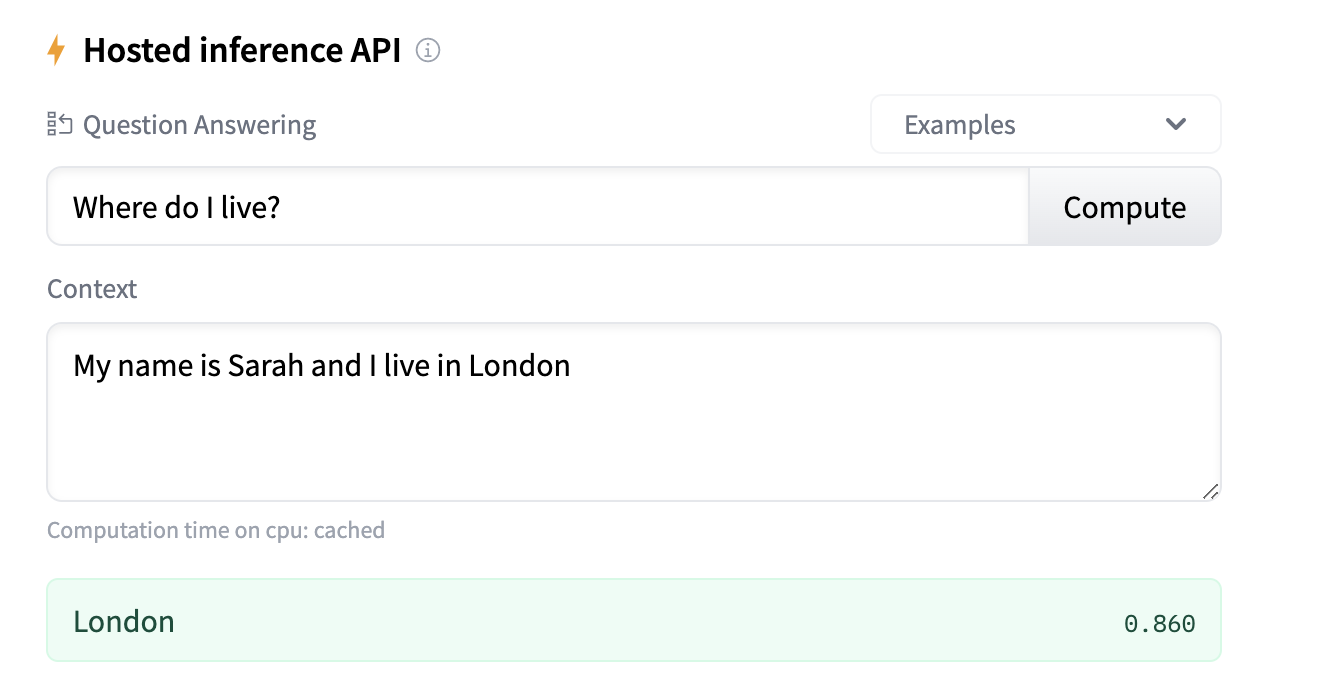

#Wandb Train

 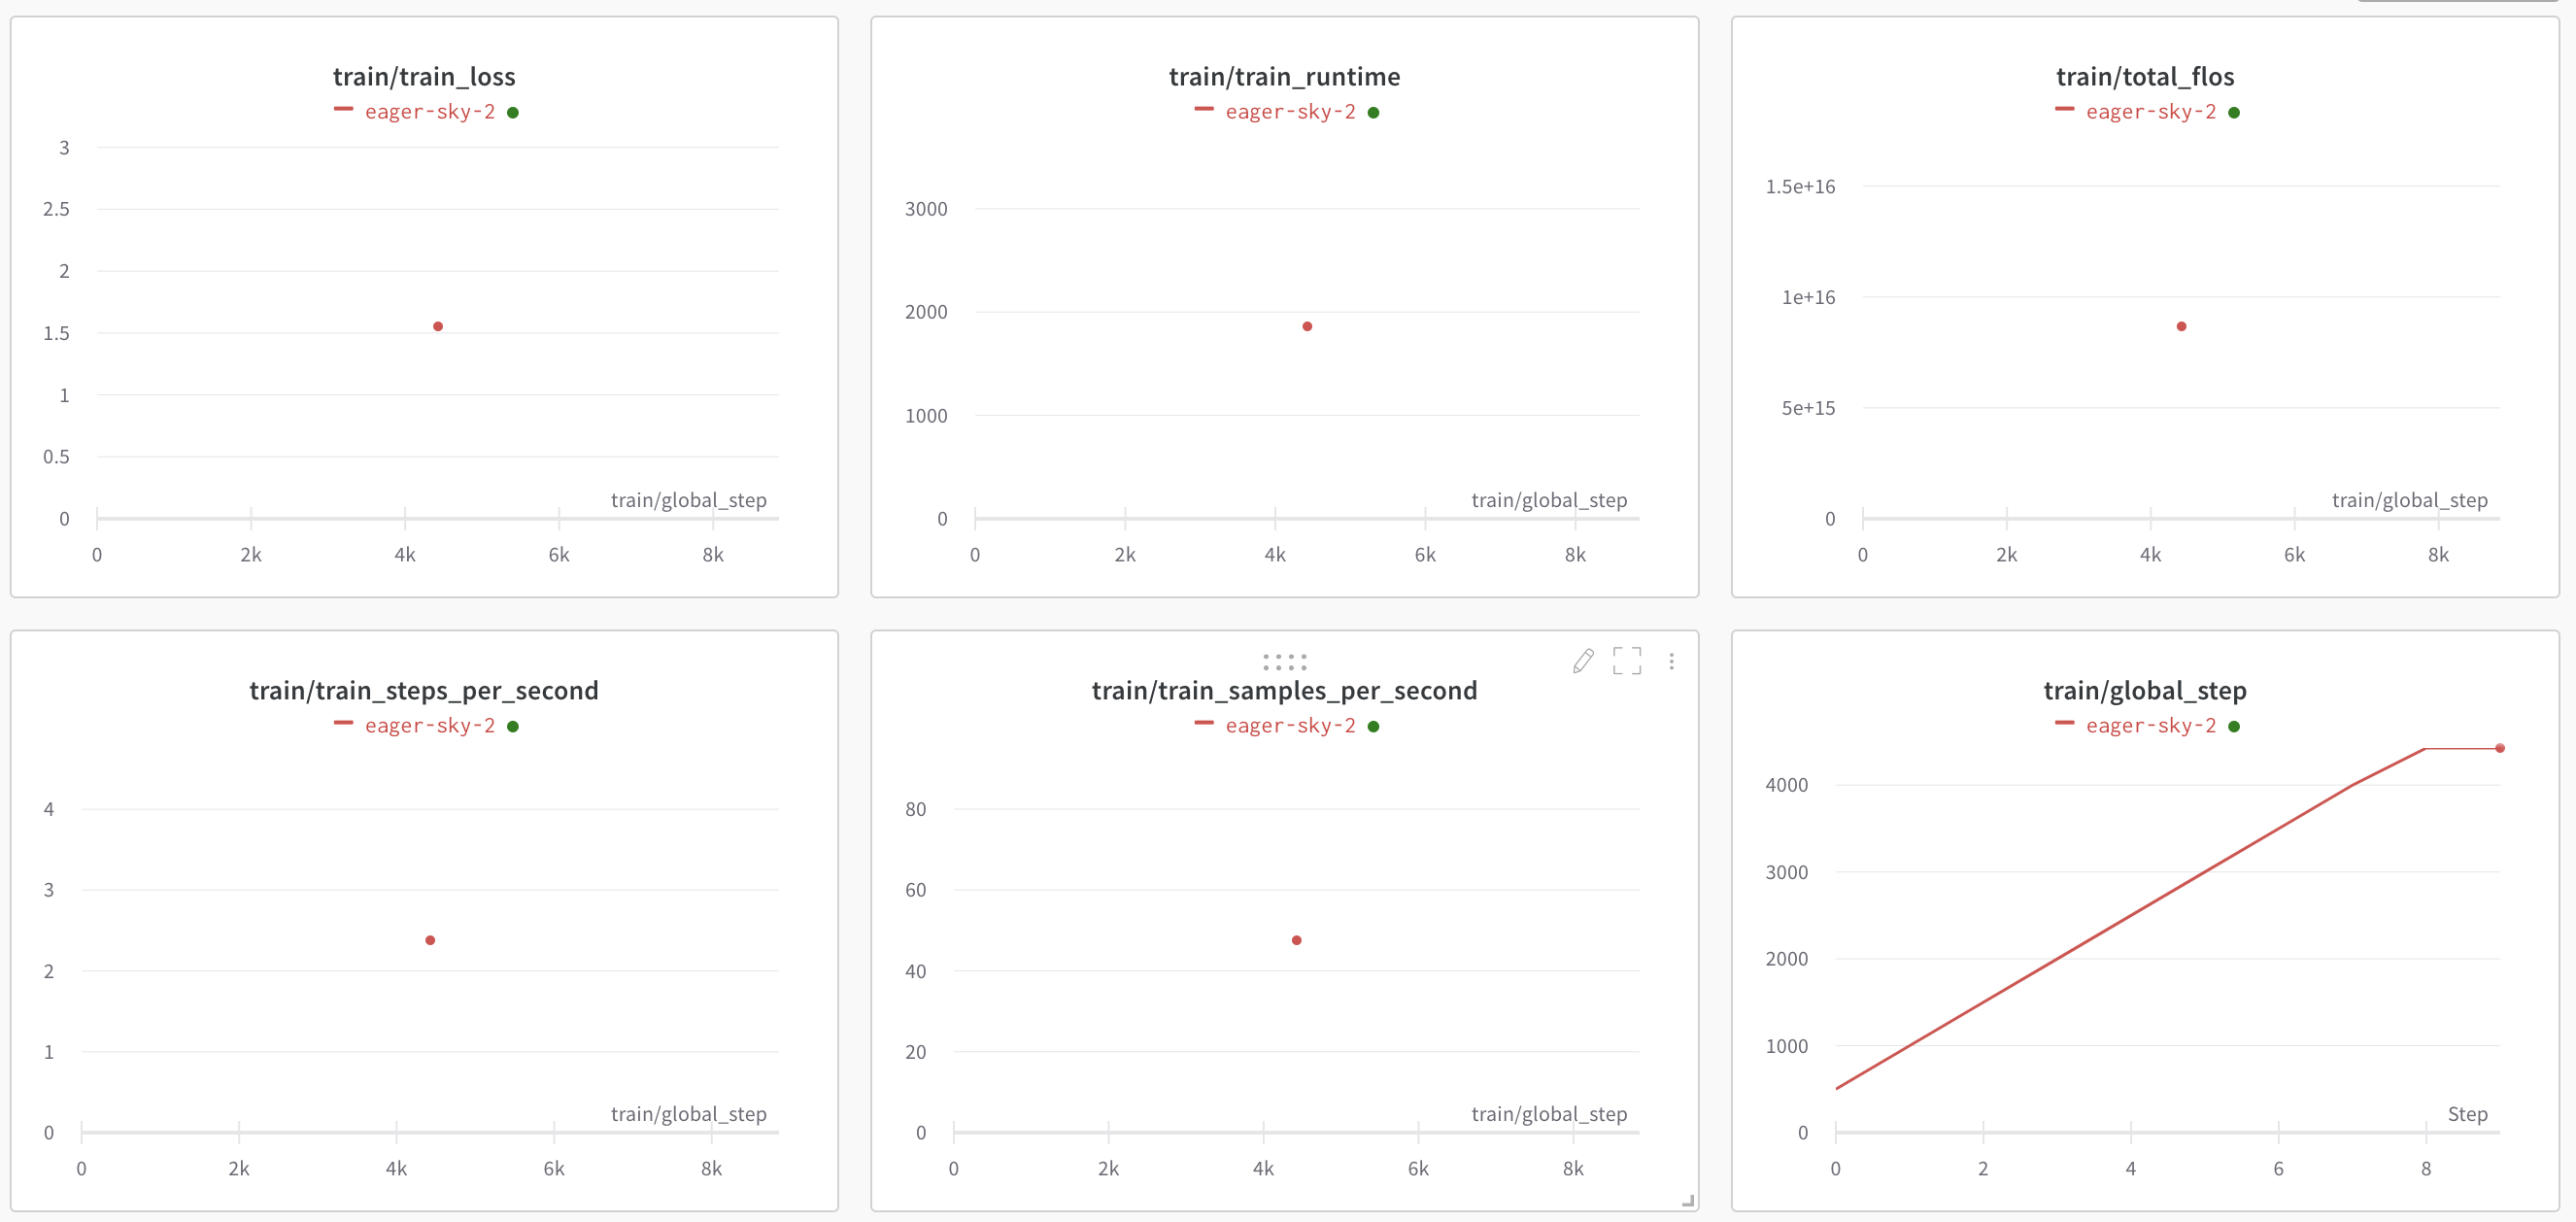

#Wandb Eval
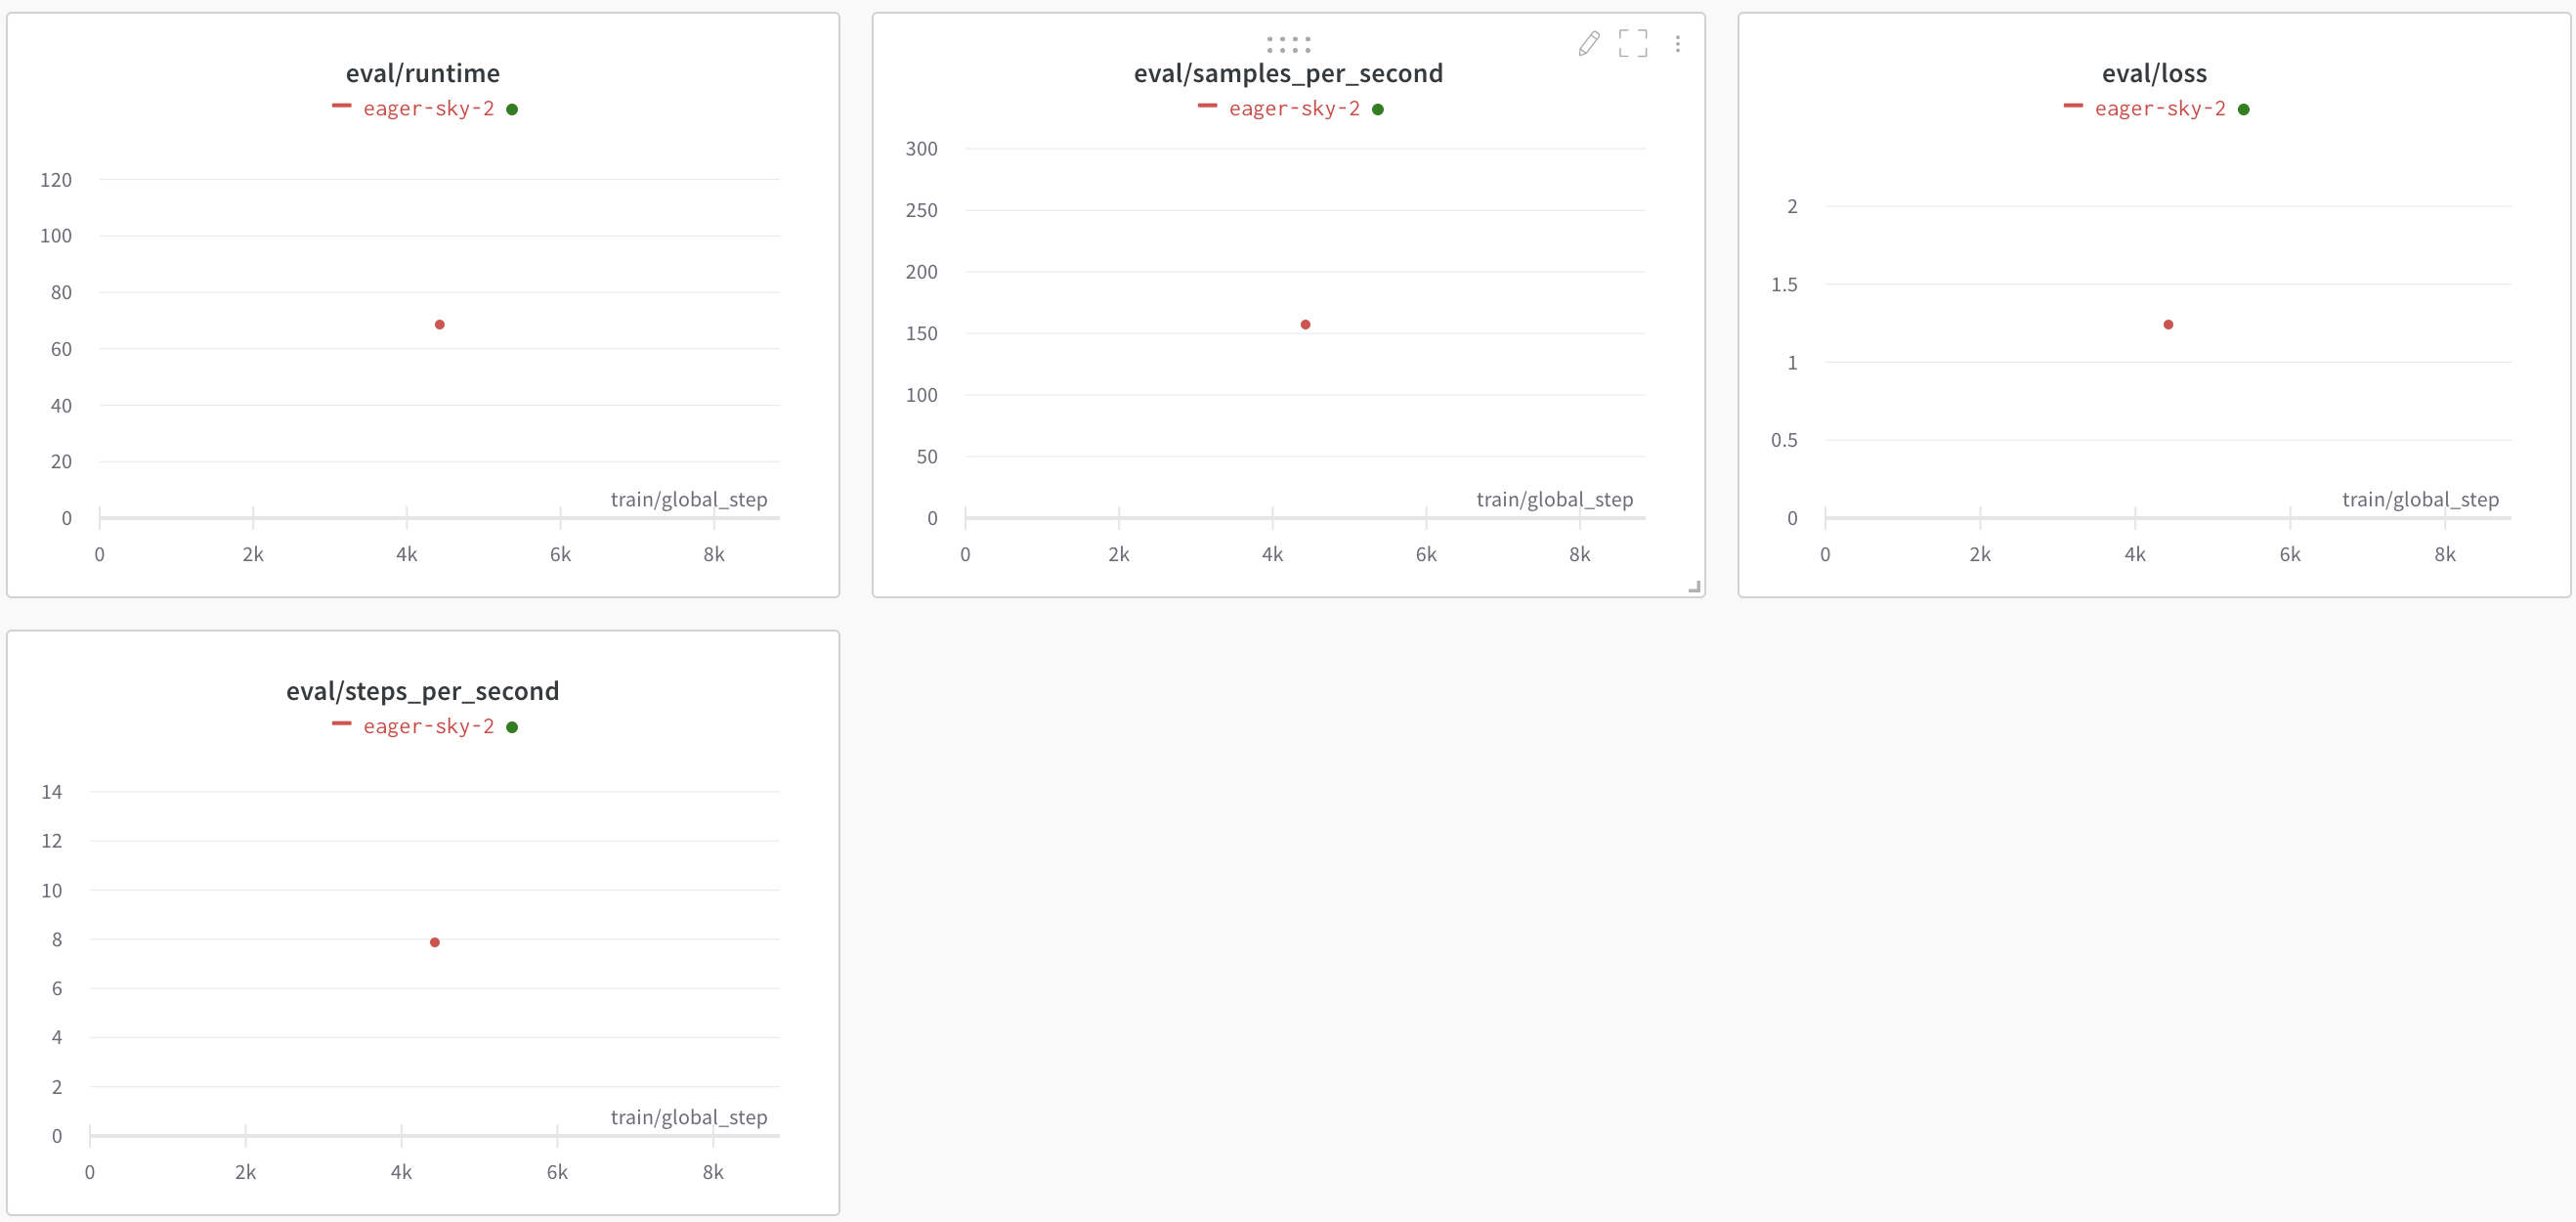